# ANN and CNN

In [1]:
import torch
from torch import nn
from torch import optim                             # used to compute the derivative
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Markdown

## Example 1:

Build a perceptron featuring three inputs and a single output. Initialize all weights ($𝑤_0$, $𝑤_2$, $𝑤_3$) to 1, considering a bias term. Take a training data point, 𝑥1=4, 𝑥2=-1, and 𝑦=1. Employ the backpropagation algorithm to demonstrate how this neural network evolves during the processing of the given training example. Set the learning rate (𝛼) to 0.5 and utilize the squared loss function.

In [11]:
x = torch.tensor([1., 4., -1.])
y = torch.tensor([1.])
w = torch.tensor([1., 1., 1.], requires_grad=True)
h = torch.matmul(w, x)
print(f'Forward Pass, h = {h}')
J = (h - y)**2
J.backward()
print(f'Backward Pass, Derivatives = {w.grad}')
w = w - 0.5*w.grad
print(f'Weights, w = {w}')

Forward Pass, h = 4.0
Backward Pass, Derivatives = tensor([ 6., 24., -6.])
Weights, w = tensor([ -2., -11.,   4.], grad_fn=<SubBackward0>)


In [22]:
x = torch.tensor([[4., -1.]])
y = torch.tensor([[1.]])
h = nn.Linear(2, 1, bias=True)
h.weight = nn.Parameter(torch.tensor([[1., 1.]]))
h.bias = nn.Parameter(torch.tensor([[1.]]))

optimizer = optim.SGD(h.parameters(), lr=0.5)
cost = nn.MSELoss()

optimizer.zero_grad()
output = h(x)
print(f'Forward Pass, h = {h}')
loss = cost(output, y)
loss.backward()
print(f'Loss = {loss.item()}')
print(f'Backward Pass, Derivative = {h.bias.grad} {h.weight.grad}')
optimizer.step()
print(f'Weights, w = , {h.weight.detach().numpy()}')

Forward Pass, h = Linear(in_features=2, out_features=1, bias=True)
Loss = 9.0
Backward Pass, Derivative = tensor([[6.]]) tensor([[24., -6.]])
Weights, w = , [[-11.   4.]]


## Example 2:

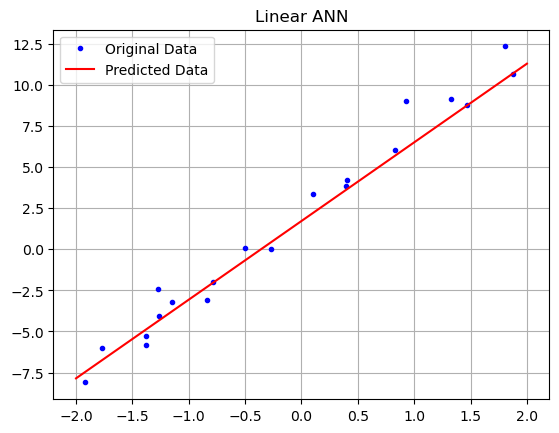

In [36]:
np.random.seed(42)
x_data = np.sort(-2. + 4. * np.random.rand(20))                 
y_data = 5. * x_data + 2.5 + np.random.randn(20)   

x_data = x_data[:, np.newaxis]
y_data = y_data[:, np.newaxis]

x = torch.tensor(x_data, dtype=torch.float32)
y = torch.tensor(y_data, dtype=torch.float32)

h = nn.Linear(1, 1, bias= True)
optimizer = optim.SGD(h.parameters(), lr = 0.1)
cost = nn.MSELoss()
losses = []
for i in range(10):
    optimizer.zero_grad()
    output = h(x)
    loss = cost(output, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

plt.plot(x_data, y_data, '.b', label='Original Data')
x_pred = np.linspace(-2.0, 2.0).reshape(-1,1)
x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = h(x_pred)
plt.plot(x_pred.detach().numpy(), y_pred.detach().numpy(),'r', label = 'Predicted Data')
plt.grid(True)
plt.title('Linear ANN')
plt.legend();

## Example 3:

In [40]:
np.random.seed(42)
hours = torch.linspace(0, 14, 100).view(-1, 1)          # 100 numbers between 0 and 14
happiness = 10 + 2 * hours + 0.2*np.random.normal(0, 5, 100).astype(np.float32).reshape(-1,1) - 0.2 * hours**2
x = hours
y = happiness

In [42]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()

        self.network = nn.Sequential(
            nn.Linear(1, 6, bias=True),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6,1)
        )

    def forward(self, x):
        return self.network(x)

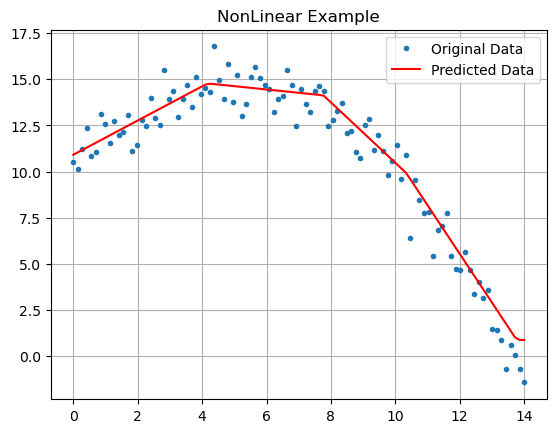

In [50]:
model = MyModel()
cost = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
losses = []
for i in range(10000):
    optimizer.zero_grad()
    output = model(x)
    loss = cost(output, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

plt.plot(x,y,'.', label='Original Data')
y_pred = model(x).detach().numpy()
plt.plot(x, y_pred, 'r', label='Predicted Data')
plt.grid(True)
plt.title('NonLinear Example')
plt.legend();

## Example 4:

In [53]:
training_data = datasets.MNIST(root='~/Downloads/VisionCNN/',
                               train=True,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()])
                               )

testing_data = datasets.MNIST(root='~/Downloads/VisionCNN/',
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()])
                               )

batch = 64
train_loader = DataLoader(training_data, batch, shuffle=True)
test_loader = DataLoader(testing_data, batch, shuffle=True)

In [56]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [57]:
train_loader.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [63]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [66]:
model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
cost = nn.NLLLoss()

J_history = []
for epoch in range(10):
    # Training
    run_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.reshape(inputs.shape[0],-1)
        optimizer.zero_grad()
        output = model(inputs)
        loss = cost(output, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    J_history+= [run_loss]


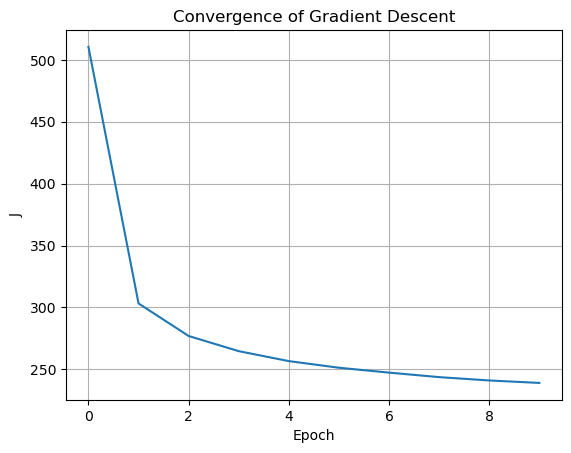

In [67]:
plt.plot(J_history)
plt.title('Convergence of Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('J')
plt.grid(True);

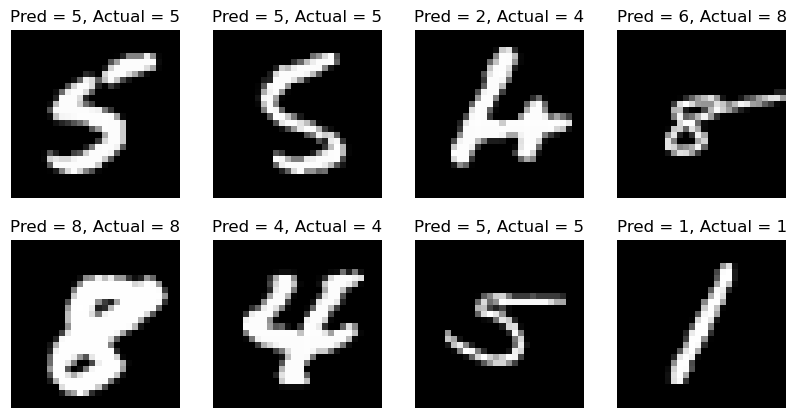

In [81]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
inputs = inputs.reshape(inputs.shape[0],-1)
output = model(inputs)
predicted = torch.argmax(output,dim=1)

plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(inputs[i].cpu().numpy().reshape(28,28), cmap='gray')
    plt.title('Pred = {}, Actual = {}'.format(predicted[i], labels[i]))
    plt.axis('off')

## Example 5:

In [82]:
torch.manual_seed(0)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_dataset = datasets.CIFAR10(
    root='~/Downloads/VisionCNN/',
    download=True,
    train=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='~/Downloads/VisionCNN/',
    download=True,
    train=False,
    transform=transform
)

batch = 64
train_dataloader = DataLoader(train_dataset, batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
train_dataloader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [85]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1),   # input: 3 x 32 x 32
                                                                                            # 4 filters of size 3 x 3
                                                                                            # output: 4 x 32 x 32
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),   # output: 8 x 32 x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),                                          # output: 8 x 8 x 8

            nn.Flatten(),                                                                   # flatten it into one vector
            nn.Linear(8*8*8, 128),                                                         
            nn.ReLU(),
            nn.Linear(128, 10) 
        )
    def forward(self, x):        
        return self.network(x)

In [86]:
model = CNN().to(device)
cost = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train = []
val = []

for epoch in range(10):
    train_loss = 0.0
    for i,(inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = cost(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train += [train_loss/len(train_dataset)]
    with torch.no_grad():
        val_loss = 0.0
        for i,(inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs)
            loss = cost(output, labels)
            val_loss += loss.item()
    
    val += [val_loss/len(test_dataset)]
    print(f'Epoch [{epoch}], train loss: {train_loss/len(train_dataset)}, val loss: {val_loss/len(test_dataset)}')        

Epoch [0], train loss: 0.025431294465065004, val loss: 0.022242926108837126
Epoch [1], train loss: 0.021208029001951217, val loss: 0.02032105326652527
Epoch [2], train loss: 0.019513395800590517, val loss: 0.01928864896297455
Epoch [3], train loss: 0.018299588514566423, val loss: 0.018702796852588653
Epoch [4], train loss: 0.017397059841156005, val loss: 0.017890065383911132
Epoch [5], train loss: 0.016750087434053422, val loss: 0.017478336656093597
Epoch [6], train loss: 0.016163044241666792, val loss: 0.017449185526371
Epoch [7], train loss: 0.01567138978242874, val loss: 0.017041877496242523
Epoch [8], train loss: 0.015186692006587982, val loss: 0.016888933998346328
Epoch [9], train loss: 0.014769701128005982, val loss: 0.016790475434064867


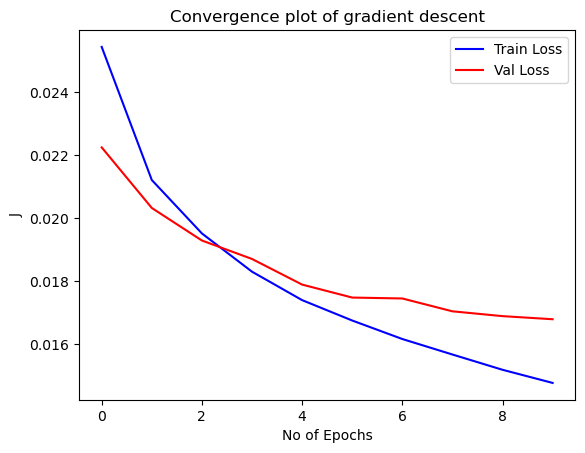

In [89]:
plt.plot(train, 'b', label='Train Loss');
plt.plot(val, 'r', label='Val Loss');
plt.title('Convergence plot of gradient descent');
plt.xlabel('No of Epochs');
plt.ylabel('J');
plt.legend();
plt.show();

Pred = airplane 	Actual = airplane
Pred = bird 	Actual = bird
Pred = truck 	Actual = truck
Pred = frog 	Actual = bird
Pred = automobile 	Actual = automobile
Pred = horse 	Actual = horse
Pred = deer 	Actual = deer
Pred = automobile 	Actual = automobile


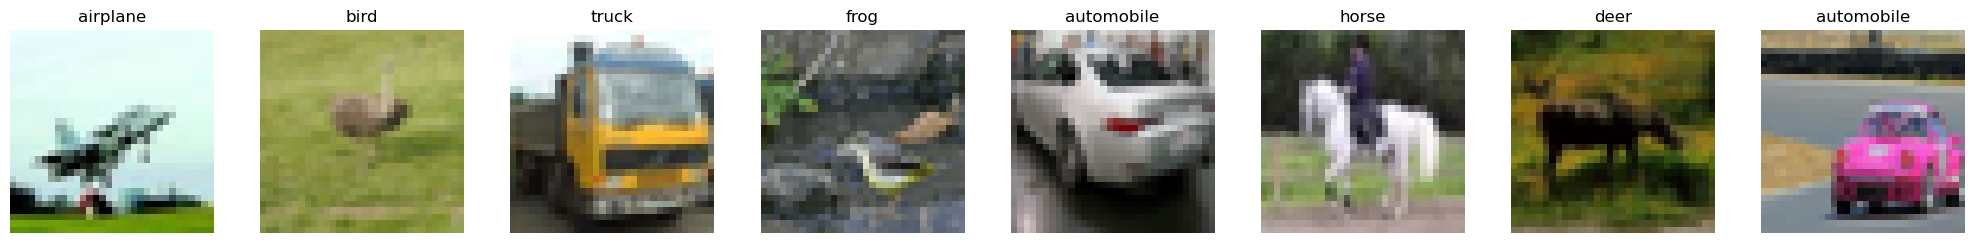

In [105]:
transform_back = transforms.Compose([transforms.Normalize((-1., -1., -1.,),(2., 2., 2.)), transforms.ToPILImage()])
inputs, labels = next(iter(test_dataloader))
inputs = inputs.to(device)
labels = labels.to(device)
output = model(inputs)
predicted = torch.argmax(output,dim=1)

idx_to_class = {value: key for key, value in train_dataset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.tight_layout()
    plt.imshow(transform_back(inputs[i]), cmap='gray')
    #plt.title(idx_to_class[labels[i].item()])
    plt.title(idx_to_class[predicted[i].item()])
    print('Pred = {} \tActual = {}'.format(idx_to_class[predicted[i].item()], idx_to_class[labels[i].item()]))
    plt.axis('off')

In [113]:
from sklearn.metrics import accuracy_score, f1_score, precision, 

accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
print('Accuracy = ', accuracy*100,'%')

Accuracy =  68.75 %
